In [32]:
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer
from sklearn.feature_selection import RFECV

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns
import time
from itertools import product
from tqdm import tqdm
from time import sleep
from tqdm.auto import tqdm

In [3]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [4]:
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [5]:
SHyper = pd.read_csv('SCouping_product_smile.csv')

In [6]:
S_CmordredC = pd.read_csv('CatalystSC.csv')
S_CmordredC_fixes = S_CmordredC.dropna(axis=1, how='any')
S_CmordredC_fix = S_CmordredC_fixes.copy()
S_CmordredC_fix.drop(S_CmordredC_fix.columns[0], axis = 1, inplace = True)
S_CmordredC_fix.rename(columns=lambda x: x + "-1", inplace=True)

S_CmordredI = pd.read_csv('ImineSC.csv')
S_CmordredI_fixes = S_CmordredI.dropna(axis=1, how='any')
S_CmordredI_fix = S_CmordredI_fixes.copy()
S_CmordredI_fix.drop(S_CmordredI_fix.columns[0], axis = 1, inplace = True)
S_CmordredI_fix.rename(columns=lambda x: x + "-2", inplace=True)

S_CmordredT = pd.read_csv('ThiolSC.csv')
S_CmordredT_fixes = S_CmordredT.dropna(axis=1, how='any')
S_CmordredT_fix = S_CmordredT_fixes.copy()
S_CmordredT_fix.drop(S_CmordredT_fix.columns[0], axis = 1, inplace = True)
S_CmordredT_fix.rename(columns=lambda x: x + "-3", inplace=True)

S_CmordredP = pd.read_csv('ProductSC.csv')
S_CmordredP_fixes = S_CmordredP.dropna(axis=1, how='any')
S_CmordredP_fix = S_CmordredP_fixes.copy()
S_CmordredP_fix.drop(S_CmordredP_fix.columns[0], axis = 1, inplace = True)
S_CmordredP_fix.rename(columns=lambda x: x + "-4", inplace=True)

In [7]:
MordredPP = pd.concat([S_CmordredC_fix, S_CmordredI_fix, S_CmordredT_fix, S_CmordredP_fix], axis = 1)

In [8]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors

In [9]:
mols1 = [Chem.MolFromSmiles(smi) for smi in SHyper['Catalyst']]
mols2 = [Chem.MolFromSmiles(smi) for smi in SHyper['Imine']]
mols3 = [Chem.MolFromSmiles(smi) for smi in SHyper['Thiol']]
mols4 = [Chem.MolFromSmiles(smi) for smi in SHyper['Product']]

In [10]:
from rdkit.Avalon import pyAvalonTools

Avs1 = [pyAvalonTools.GetAvalonFP(mol, nBits=2048) for mol in mols1]
df_Avs1 = pd.DataFrame(np.array(Avs1))
df_Avs1.columns = [f'1_{col}' for col in df_Avs1.columns]

Avs2 = [pyAvalonTools.GetAvalonFP(mol, nBits=2048) for mol in mols2]
df_Avs2 = pd.DataFrame(np.array(Avs2))
df_Avs2.columns = [f'2_{col}' for col in df_Avs2.columns]

Avs3 = [pyAvalonTools.GetAvalonFP(mol, nBits=2048) for mol in mols3]
df_Avs3 = pd.DataFrame(np.array(Avs3))
df_Avs3.columns = [f'3_{col}' for col in df_Avs3.columns]

Avs4 = [pyAvalonTools.GetAvalonFP(mol, nBits=2048) for mol in mols4]
df_Avs4 = pd.DataFrame(np.array(Avs4))
df_Avs4.columns = [f'4_{col}' for col in df_Avs4.columns]

In [11]:
Avs_PEMF = pd.concat([df_Avs1, df_Avs2, df_Avs3, df_Avs4], axis = 1)

In [12]:
SPP_columns = ['SMR_VSA9-1', 'nAromAtom-3']

In [13]:
SPP = MordredPP[SPP_columns]

In [14]:
SPP_Avs_PEMF = pd.concat([SPP, Avs_PEMF], axis = 1)

In [15]:
X_full = SPP_Avs_PEMF
y = SHyper.iloc[:,-2].copy()

In [16]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X_full, y, test_size=475, random_state=49)

In [28]:
X_train_base = X_train_full.iloc[:, 2:]  
X_train_meta = X_train_full.iloc[:, :2]  
X_test_base = X_test.iloc[:, 2:]
X_test_meta = X_test.iloc[:, :2]

In [29]:
base_models = [
    ('rf', RandomForestRegressor(n_estimators=1500, max_features = 0.2, random_state=49)),
    ('xgb', XGBRegressor(objective="reg:squarederror", n_estimators=20, learning_rate=0.2, random_state=49)),
    ('et', ExtraTreesRegressor(n_estimators=600, max_features = 0.2, random_state=49)),
    ('dt', DecisionTreeRegressor(max_depth=9, min_samples_split=8, random_state=49)),
    ('krr', KernelRidge(kernel='rbf', alpha=0.005, gamma=0.001))
]

In [30]:
kf = KFold(n_splits=5, shuffle=True, random_state=49)
meta_features_train = np.zeros((X_train_base.shape[0], len(base_models)))

In [81]:
# for i, (name, model) in enumerate(base_models):
#     print(f"Training base model {name}")
#     for train_idx, val_idx in kf.split(X_train_base):
#         X_tr, X_val = X_train_base.iloc[train_idx], X_train_base.iloc[val_idx]
#         y_tr = y_train_full.iloc[train_idx]
#         model.fit(X_tr, y_tr)
#         meta_features_train[val_idx, i] = model.predict(X_val)

Training base model rf
Training base model xgb
Training base model et
Training base model dt
Training base model krr


In [33]:
for i, (name, model) in enumerate(tqdm(base_models, desc="Training base models")):
    start_time = time.time()
    
    print(f"Training base model {name}")
    for train_idx, val_idx in kf.split(X_train_base):
        X_tr, X_val = X_train_base.iloc[train_idx], X_train_base.iloc[val_idx]
        y_tr = y_train_full.iloc[train_idx]
        model.fit(X_tr, y_tr)
        meta_features_train[val_idx, i] = model.predict(X_val)
    
    elapsed = time.time() - start_time
    print(f" {name} finished in {elapsed:.2f} seconds.\n")

Training base models:   0%|          | 0/5 [00:00<?, ?it/s]

Training base model rf
 rf finished in 153.30 seconds.

Training base model xgb
 xgb finished in 3.69 seconds.

Training base model et
 et finished in 72.04 seconds.

Training base model dt
 dt finished in 0.59 seconds.

Training base model krr
 krr finished in 0.76 seconds.



In [34]:
meta_features_test = np.zeros((X_test_base.shape[0], len(base_models)))

In [35]:
for i, (name, model) in enumerate(base_models):
    model.fit(X_train_base, y_train_full)  # 在完整训练集上训练
    meta_features_test[:, i] = model.predict(X_test_base)

In [36]:
meta_features_train = np.hstack([meta_features_train, X_train_meta.values])
meta_features_test = np.hstack([meta_features_test, X_test_meta.values])

In [37]:
meta_model = XGBRegressor(objective="reg:squarederror", random_state=49)
param_grid_meta = {
    'n_estimators': [10, 20, 30, 40, 50, 70, 90, 100, 300, 500],
    'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
    'max_depth': [2, 3, 4, 6],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

In [38]:
scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

In [39]:
grid_search_meta = GridSearchCV(
    estimator=meta_model,
    param_grid=param_grid_meta,
    scoring=scorer,
    cv=3,  # 3折CV足够，因训练集仅600
    n_jobs=-1,
    verbose=2
)

In [40]:
for _ in tqdm(range(1), desc="Meta-model grid search"):
    grid_search_meta.fit(meta_features_train, y_train_full)

best_meta_model = grid_search_meta.best_estimator_

Meta-model grid search:   0%|          | 0/1 [00:00<?, ?it/s]

Fitting 3 folds for each of 1800 candidates, totalling 5400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:   47.0s
[Parallel(n_jobs=-1)]: Done 965 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1937 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2544 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 3233 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 4853 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 5400 out of 5400 | elapsed:  7.6min finished


In [41]:
print("Best Meta Model Parameters:", grid_search_meta.best_params_)
print("Best Meta Model RMSE:", -grid_search_meta.best_score_)

Best Meta Model Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'subsample': 1.0}
Best Meta Model RMSE: 0.20284990341812947


In [42]:
y_train_pred = best_meta_model.predict(meta_features_train)
train_rmse = np.sqrt(mean_squared_error(y_train_full, y_train_pred))
train_mae = mean_absolute_error(y_train_full, y_train_pred)
train_r2 = r2_score(y_train_full, y_train_pred)

y_test_pred = best_meta_model.predict(meta_features_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

In [43]:
print(f"  Train RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
print(f"  Test RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}")

  Train RMSE: 0.1291, MAE: 0.0964, R²: 0.9660
  Test RMSE: 0.2016, MAE: 0.1379, R²: 0.9170


In [92]:
best_params = grid_search_meta.best_params_

In [93]:
print(f"  Best meta-model params: {best_params}")

  Best meta-model params: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500, 'subsample': 1.0}


In [94]:
import matplotlib.pyplot as plt

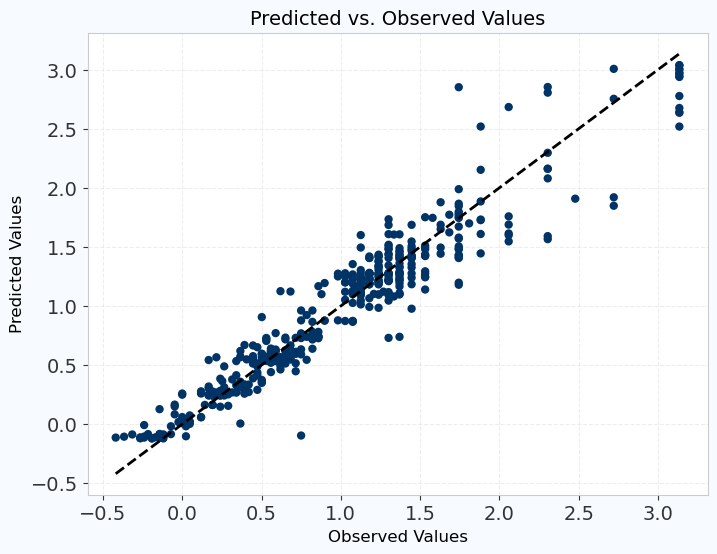

In [97]:
plt.figure(figsize=(8, 6), facecolor='#F7FBFF') # 设置整个图像的背景颜色

# 绘制散点图
plt.scatter(y_test, y_test_pred, alpha=1, color='#003366', edgecolors='none', zorder=2)

# 添加理想拟合线（y = x），表示完美预测
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
        color='black', linestyle='--', linewidth=2, zorder=3)

# 添加标签和标题
plt.xlabel('Observed Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Predicted vs. Observed Values', fontsize=14)

# 设置网格线样式
plt.grid(True, linestyle='--', color='#DDDDDD', alpha=0.5, zorder=0)

# 设置坐标轴的刻度标签颜色为深灰色
plt.gca().tick_params(axis='x', colors='#333333', labelsize=14)
plt.gca().tick_params(axis='y', colors='#333333', labelsize=14)

# 设置坐标轴和边框的颜色为浅灰色
for spine in plt.gca().spines.values():
    spine.set_edgecolor('#CCCCCC')


plt.savefig('predicted_vs_observed_values2.png', dpi=300, bbox_inches='tight')

# 显示图形
plt.show()